In [3]:
#!pip install keras

In [4]:
#!pip install git+https://github.com/keras-team/keras-tuner.git@1.0.2rc1

In [1]:
pip show autokeras

Name: autokeras
Version: 1.0.19
Summary: AutoML for deep learning
Home-page: http://autokeras.com
Author: DATA Lab, Keras Team
Author-email: jhfjhfj1@gmail.com
License: Apache License 2.0
Location: /home/rpezoa/.local/lib/python3.7/site-packages
Requires: tensorflow, packaging, pandas, keras-tuner
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
seed_=0

In [3]:
# Read data file
df = pd.read_csv("../HEP_Data_Analysis/hep_shap/data/higgs/phpZLgL9q.csv")
df.rename(columns = {'class': 'label'}, inplace = True)
# Removing last row containinng "?" values
df.drop(df.tail(1).index,inplace=True) # drop last n rows
df = df.apply(pd.to_numeric)
# Pandas dataframe for correlation matrix without label column
df_corr = df.drop('label', inplace=False, axis=1)

/home/lmod/software/Anaconda3/2020.02/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (20,21,22,23,24,25,26,27,28) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
# Scaling data
y = df["label"]
X = df.iloc[:,1:]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)
df_scaled = pd.DataFrame(scaled_data, columns=X.columns)


# Training, validation, and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed_)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, shuffle = True, test_size=0.2, random_state=seed_)

In [5]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(62751, 28) (19610, 28) (62751,) (19610,)


In [6]:
#!pip install keras-tuner --upgrade

In [7]:
from autokeras import StructuredDataClassifier

In [8]:
search = StructuredDataClassifier(max_trials=2)

INFO:tensorflow:Reloading Oracle from existing project ./structured_data_classifier/oracle.json
INFO:tensorflow:Reloading Tuner from ./structured_data_classifier/tuner0.json


In [10]:
search.fit(x=X_train, y=y_train, verbose=0)
# evaluate the model
loss, acc = search.evaluate(X_test, y_test, verbose=4, validation_data=(X_val, y_val))
print('Accuracy: %.3f' % acc)

INFO:tensorflow:Oracle triggered exit
1961/1961 [==============================] - 7s 3ms/step - loss: 0.6396 - accuracy: 0.6340
INFO:tensorflow:Assets written to: ./structured_data_classifier/best_model/assets
Accuracy: 0.671


In [13]:
yhat = search.predict(X_test)
print('Predicted: %.3f' % yhat[0])

model = search.export_model()
model.summary()


613/613 [==============================] - 1s 2ms/step
Predicted: 1.000
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28)]              0         
                                                                 
 multi_category_encoding (Mu  (None, 28)               0         
 ltiCategoryEncoding)                                            
                                                                 
 normalization (Normalizatio  (None, 28)               57        
 n)                                                              
                                                                 
 dense (Dense)               (None, 1024)              29696     
                                                                 
 re_lu (ReLU)                (None, 1024)              0         
                                                       

In [14]:
type(model)

keras.engine.functional.Functional

In [16]:
model.save("test_higgs_autorkeras.tf",save_format='tf')

INFO:tensorflow:Assets written to: test_higgs_autorkeras.tf/assets


In [17]:
from tensorflow import keras

In [18]:
loaded_model = keras.models.load_model("test_higgs_autorkeras.tf")

In [19]:
loaded_model

In [20]:
y_pred = loaded_model.predict(X_test)

613/613 [==============================] - 2s 2ms/step


In [21]:
y_pred

array([[0.60065126],
       [0.5891997 ],
       [0.39378986],
       ...,
       [0.75890565],
       [0.66842705],
       [0.55663997]], dtype=float32)

In [22]:
loaded_model.history

In [23]:
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28)]              0         
                                                                 
 multi_category_encoding (Mu  (None, 28)               0         
 ltiCategoryEncoding)                                            
                                                                 
 normalization (Normalizatio  (None, 28)               57        
 n)                                                              
                                                                 
 dense (Dense)               (None, 1024)              29696     
                                                                 
 re_lu (ReLU)                (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0     

In [24]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
y_pred_val = model.predict(X_val)

491/491 [==============================] - 1s 2ms/step


In [26]:
import mplhep as hep

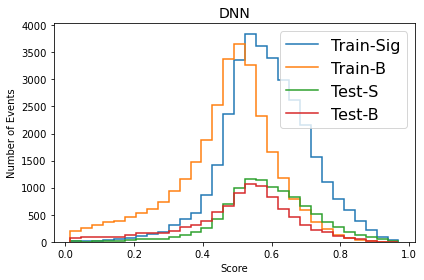

In [27]:
f, axs = plt.subplots(1, 1, sharex=True, sharey=True)
h_signal_train, bins_sig_train = np.histogram(y_pred_train[y_train == 1], bins=30)
h_back_train, bins_back_train = np.histogram(y_pred_train[y_train == 0], bins=30)
h_sig_test, bins_sig_test = np.histogram(y_pred_test[y_test == 1], bins=30)
h_back_test, bins_back_test = np.histogram(y_pred_test[y_test == 0], bins=30)

axs.set_title("DNN", fontsize=14)
hep.histplot([h_signal_train,h_back_train, h_sig_test, h_back_test], bins_sig_test, ax=axs,label=["Train-Sig", "Train-B", "Test-S", "Test-B"])
axs.legend(fontsize=16)
axs.set_xlabel("Score")
axs.set_ylabel("Number of Events")

plt.tight_layout()
plt.show()

In [31]:
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, accuracy_score
from sklearn.metrics import f1_score as f1s
th=0.45
fpr, tpr, ths = roc_curve(y_test,  y_pred_test)
auc_ = auc(fpr, tpr)
f1 = f1s(y_test,  (y_pred_test>th))
prec = precision_score(y_test,  (y_pred_test>th))
rec = recall_score(y_test,  (y_pred_test>th))
acc = accuracy_score(y_test,  (y_pred_test>th))
print("F1: %.2f" %f1 , " -- prec: %.2f" %prec, " -- recall: %.2f" %rec, " -- acc: %.2f" %acc)

F1: 0.72  -- prec: 0.61  -- recall: 0.89  -- acc: 0.64


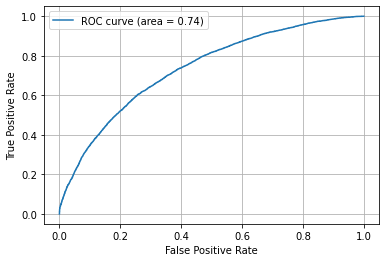

In [32]:
#create ROC curve
plt.plot(fpr,tpr, label='ROC curve (area = %.2f)' %auc_)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.grid()
plt.show()